### 11. Kmean clustering using weighted eucledean distance
Gayantha R. L. Kodikara 18/01/2024 @ UWM Revised: 16/01/2024, 08/03/2024, 05/04/2024, 31/05/2024

Sources: https://blog.paperspace.com/speed-up-kmeans-numpy-vectorization-broadcasting-profiling/

In [1]:
from time import time as Time
t1 = Time()
import numpy as np 
import matplotlib.pyplot as plt 
from osgeo import gdal, gdal_array, ogr, osr
import time 
from osgeo_utils.gdal_sieve import gdal_sieve
import math

In [2]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
img_ds = gdal.Open('Pininj_0177_DSL_IDX_4B.tif', gdal.GA_ReadOnly)
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
              gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

In [4]:
for b in range(img.shape[2]):
    img[:,:,b] = img_ds.GetRasterBand(b+1).ReadAsArray()

new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print(img.shape)
print(new_shape)
X = img[:,:,:5].reshape(new_shape)
print(X.shape)

(900, 1200, 4)
(1080000, 4)
(1080000, 4)


In [5]:
num_iters = 100
k = 12 # num_clusters
weights = [1,1,1,1]

In [6]:
# Set random seed for reproducibility 
np.random.seed(0)

# Initialise centroids
centroids = X[np.random.choice(range(X.shape[0]), k)]
# Create a list to store which centroid is assigned to each dataset
assigned_centroids = np.zeros(len(X), dtype = np.int32)

In [7]:
def compute_eu_distance(x, centroid, weights):
    # Compute the difference, following by raising to power 2 and summing
    dist = np.sqrt((((x - centroid) * weights) ** 2).sum(axis = x.ndim - 1))    
    return dist

In [8]:
def get_closest_centroid(x, centroids):    
    # Loop over each centroid and compute the distance from data point.
    dist = compute_eu_distance(x, centroids, weights)
    # Get the index of the centroid with the smallest distance to the data point 
    closest_centroid_index =  np.argmin(dist, axis = 1)    
    return closest_centroid_index

In [9]:
def compute_sse(X, centroids, assigned_centroids):
    # Initialise SSE 
    sse = 0
    # Compute SSE
    sse = compute_eu_distance(X, centroids[assigned_centroids], weights).sum() / len(X)   
    return sse

In [10]:
# Number of dimensions in centroid
num_centroid_dims = X.shape[1]

# List to store SSE for each iteration 
sse_list = []

In [11]:
# Start time
tic = time.time()
# Main Loop
for n in range(50):
    # Get closest centroids to each data point
    assigned_centroids = get_closest_centroid(X[:, None, :], centroids[None,:, :])    
    
    # Compute new centroids
    for c in range(centroids.shape[1]):
        # Get data points belonging to each cluster 
        cluster_members = X[assigned_centroids == c]
        
        # Compute the mean of the clusters
        cluster_members = cluster_members.mean(axis = 0)
        
        # Update the centroids
        centroids[c] = cluster_members
    
    # Compute SSE
    sse = compute_sse(X.squeeze(), centroids.squeeze(), assigned_centroids)
    sse_list.append(sse)

# End time
toc = time.time()

print(round(toc - tic,3))

74.895


In [12]:
X_cluster = assigned_centroids.reshape(img[:,:,0].shape)

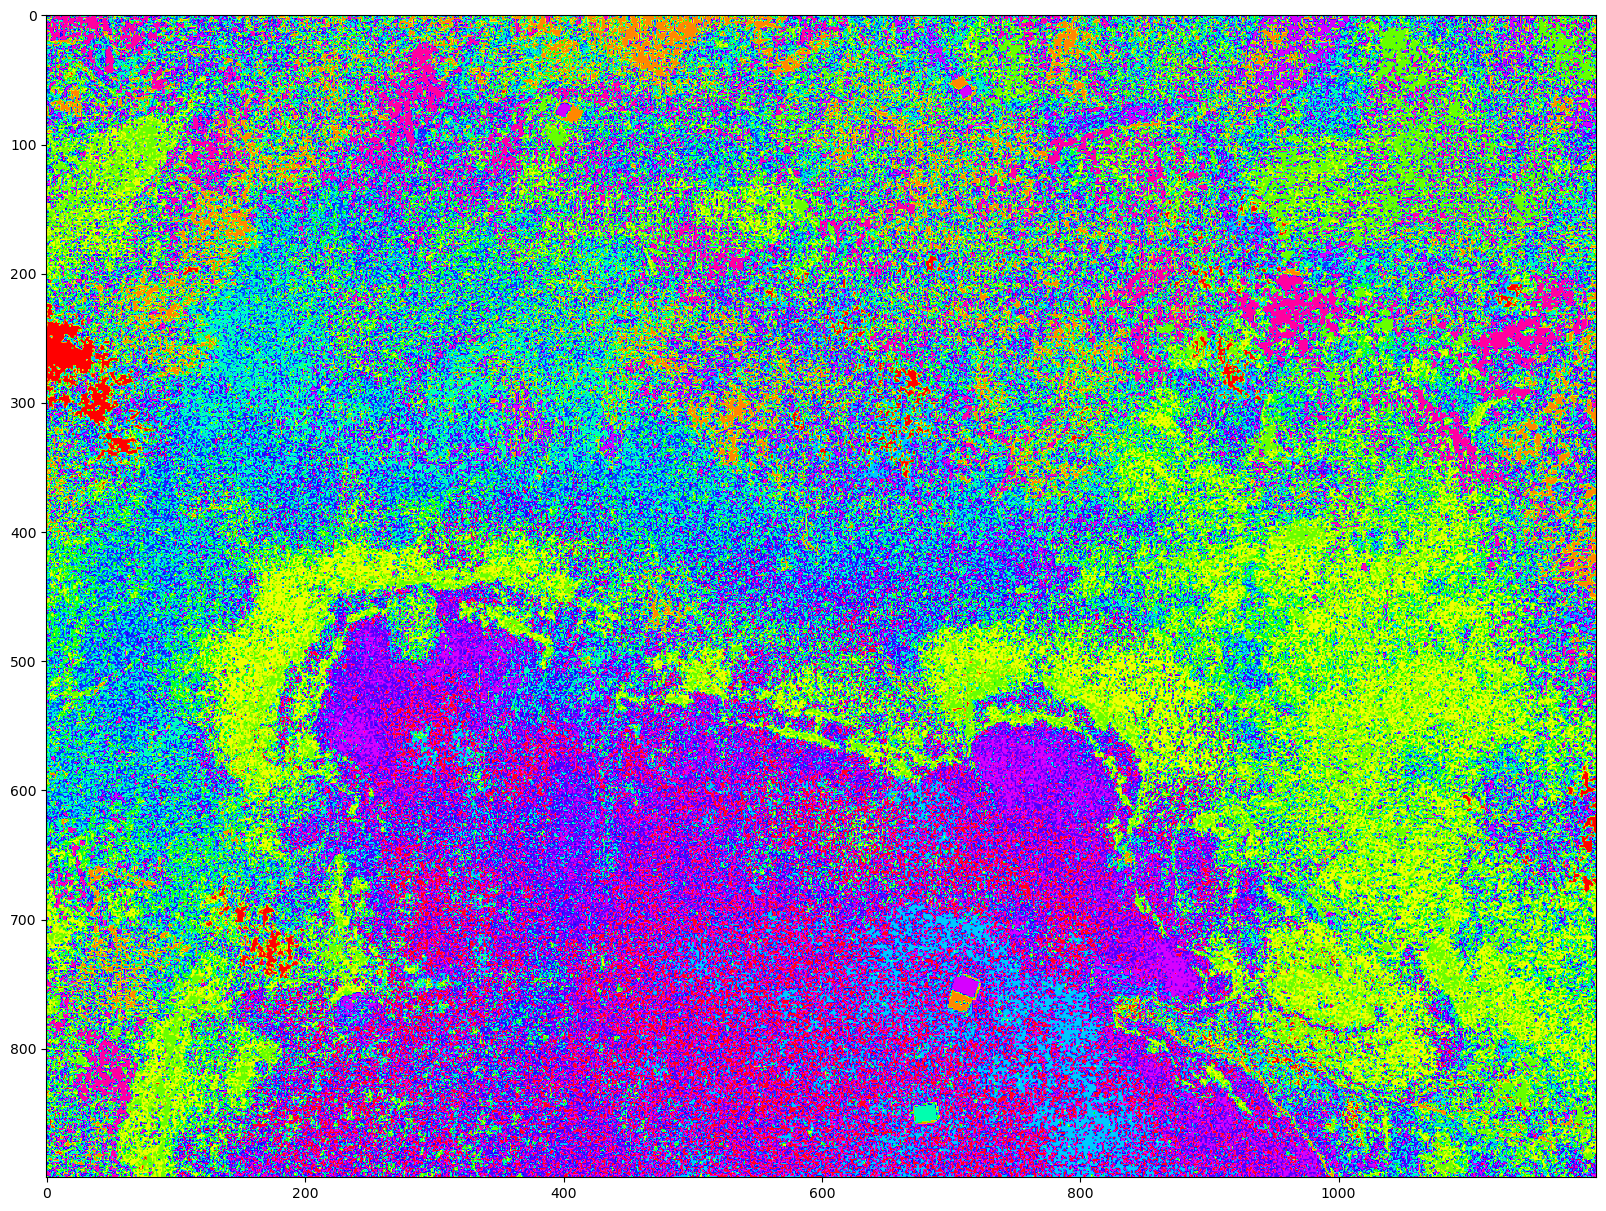

In [13]:
%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")
#plt.savefig('07Kmeans20_6B_Idx2.png', dpi=600)
plt.show()

In [14]:
band = img_ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
driver = gdal.GetDriverByName("GTiff")

In [25]:
outDataRaster = driver.Create("Pininj_0177_DSL_Idx_4B_kmean_12cls_6.tiff", rows, cols, 1, gdal.GDT_Byte)
#outDataRaster.SetGeoTransform(img_ds.GetGeoTransform())
#outDataRaster.SetProjection(img_ds.GetProjection())
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)
outDataRaster.FlushCache()
del outDataRaster

In [26]:
t2 = Time()
print(t2 - t1)

906.1827363967896


In [27]:
Image = gdal.Open('Pininj_0177_DSL_Idx_4B_kmean_12cls_6.tiff', 1)  # open image in read-write mode
Band = Image.GetRasterBand(1)
gdal.SieveFilter(srcBand=Band, maskBand=None, dstBand=Band, threshold=6, connectedness=8, callback=gdal.TermProgress_nocb)
del Image, Band  # close the datasets.

In [18]:
in_path = 'Pininj_0177_DSL_Idx_5B_kmean_12cls15w.tiff'

out_path = 'Pininj_0177_DSL_Idx_5B_kmean_12cls_polygon.shp'

#  get raster datasource
src_ds = gdal.Open( in_path )
prj = src_ds.GetProjection()
#
srcband = src_ds.GetRasterBand(1)
dst_layername = 'Kmean_Classes'
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource( out_path )

sp_ref = osr.SpatialReference(wkt=prj)
#sp_ref = osr.SpatialReference()
#sp_ref.SetFromUserInput('EPSG:4326')

#dst_layer = dst_ds.CreateLayer(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername, srs = sp_ref )
fld = ogr.FieldDefn("Class", ogr.OFTInteger)
dst_layer.CreateField(fld)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex("Class")

gdal.Polygonize( srcband, None, dst_layer, dst_field, [], callback=None )

#del src_ds
del dst_ds

In [19]:
flip_path = "Pininj_0177_DSL_Idx_5B_kmean_12cls_flip.tiff"
driver_tiff = gdal.GetDriverByName("GTiff")
ds_copy = driver_tiff.CreateCopy(flip_path, src_ds, strict=0)
ds_copy = None
del src_ds

In [20]:
# open dataset as readable/writable
ds = gdal.Open('Pininj_0177_DSL_Idx_5B_kmean_12cls_flip.tiff', gdal.GA_Update)
# get the GeoTransform as a tuple
gt =ds.GetGeoTransform()
# change gt[5] to be it's negative, flipping the image
gt_new = (gt[0], gt[1], gt[2], gt[3], gt[4], -1 * gt[5])
# set the new GeoTransform, effectively flipping the image
ds.SetGeoTransform(gt_new)
# delete the dataset reference, flushing the cache of changes
del ds

In [21]:
ref_img = np.load('Pininj_0177_DSL_np3D.npy')
ref_img.shape

FileNotFoundError: [Errno 2] No such file or directory: 'Pininj_0177_DSL_np3D.npy'

In [ ]:
cls_img = X_cluster[:,:,None]
cls_img.shape

In [ ]:
# Create empty image
array = np.zeros((900,1200,6))
array[:,:,0] = ref_img[:,:,0]
array[:,:,1] = ref_img[:,:,1]
array[:,:,2] = ref_img[:,:,2]
array[:,:,3] = ref_img[:,:,4]
array[:,:,4] = ref_img[:,:,3]
array[:,:,5] = cls_img[:,:,0]

In [ ]:
new_array = (array.shape[0] * array.shape[1], array.shape[2])
print(array.shape)
print(new_array)
clx = array[:,:,:].reshape(new_array)
clx = np.around(clx,5)
print(clx.shape)

In [ ]:
#class 1
mask_1 = np.where(clx[:,5] ==0)
clx_1 = clx[mask_1]
clx_1_mean = np.mean(clx_1[:,:-1], axis = 0)
clx_1_min = np.min(clx_1[:,:-1], axis = 0)
clx_1_max = np.max(clx_1[:,:-1], axis = 0)
#class 2
mask_2 = np.where(clx[:,5] ==1)
clx_2 = clx[mask_2]
clx_2_mean = np.mean(clx_2[:,:-1], axis = 0)
clx_2_min = np.min(clx_2[:,:-1], axis = 0)
clx_2_max = np.max(clx_2[:,:-1], axis = 0)
#class 3
mask_3 = np.where(clx[:,5] ==2)
clx_3 = clx[mask_3]
clx_3_mean = np.mean(clx_3[:,:-1], axis = 0)
clx_3_min = np.min(clx_3[:,:-1], axis = 0)
clx_3_max = np.max(clx_3[:,:-1], axis = 0)
#class 4
mask_4 = np.where(clx[:,5] ==3)
clx_4 = clx[mask_4]
clx_4_mean = np.mean(clx_4[:,:-1], axis = 0)
clx_4_min = np.min(clx_4[:,:-1], axis = 0)
clx_4_max = np.max(clx_4[:,:-1], axis = 0)
#class 5
mask_5 = np.where(clx[:,5] ==4)
clx_5 = clx[mask_5]
clx_5_mean = np.mean(clx_5[:,:-1], axis = 0)
clx_5_min = np.min(clx_5[:,:-1], axis = 0)
clx_5_max = np.max(clx_5[:,:-1], axis = 0)
#class 6
mask_6 = np.where(clx[:,5] ==5)
clx_6 = clx[mask_6]
clx_6_mean = np.mean(clx_6[:,:-1], axis = 0)
clx_6_min = np.min(clx_6[:,:-1], axis = 0)
clx_6_max = np.max(clx_6[:,:-1], axis = 0)
#class 7
mask_7 = np.where(clx[:,5] ==6)
clx_7 = clx[mask_7]
clx_7_mean = np.mean(clx_7[:,:-1], axis = 0)
clx_7_min = np.min(clx_7[:,:-1], axis = 0)
clx_7_max = np.max(clx_7[:,:-1], axis = 0)
#class 8
mask_8 = np.where(clx[:,5] ==7)
clx_8 = clx[mask_8]
clx_8_mean = np.mean(clx_8[:,:-1], axis = 0)
clx_8_min = np.min(clx_8[:,:-1], axis = 0)
clx_8_max = np.max(clx_8[:,:-1], axis = 0)
#class 9
mask_9 = np.where(clx[:,5] ==8)
clx_9 = clx[mask_9]
clx_9_mean = np.mean(clx_9[:,:-1], axis = 0)
clx_9_min = np.min(clx_9[:,:-1], axis = 0)
clx_9_max = np.max(clx_9[:,:-1], axis = 0)
#class 10
mask_10 = np.where(clx[:,5] ==9)
clx_10 = clx[mask_10]
clx_10_mean = np.mean(clx_10[:,:-1], axis = 0)
clx_10_min = np.min(clx_10[:,:-1], axis = 0)
clx_10_max = np.max(clx_10[:,:-1], axis = 0)
#class 11
mask_11 = np.where(clx[:,5] ==10)
clx_11 = clx[mask_11]
clx_11_mean = np.mean(clx_11[:,:-1], axis = 0)
clx_11_min = np.min(clx_11[:,:-1], axis = 0)
clx_11_max = np.max(clx_11[:,:-1], axis = 0)
#class 12
mask_12 = np.where(clx[:,5] ==11)
clx_12 = clx[mask_12]
clx_12_mean = np.mean(clx_12[:,:-1], axis = 0)
clx_12_min = np.min(clx_12[:,:-1], axis = 0)
clx_12_max = np.max(clx_12[:,:-1], axis = 0)
#class 13
#mask_13 = np.where(clx[:,5] ==12)
#clx_13 = clx[mask_13]
#clx_13_mean = np.mean(clx_13[:,:-1], axis = 0)
#clx_13_min = np.min(clx_13[:,:-1], axis = 0)
#clx_13_max = np.max(clx_13[:,:-1], axis = 0)
#class 14
#mask_14 = np.where(clx[:,5] ==13)
#clx_14 = clx[mask_14]
#clx_14_mean = np.mean(clx_14[:,:-1], axis = 0)
#clx_14_min = np.min(clx_14[:,:-1], axis = 0)
#clx_14_max = np.max(clx_14[:,:-1], axis = 0)
#class 15
#mask_15 = np.where(clx[:,5] ==14)
#clx_15 = clx[mask_15]
#clx_15_mean = np.mean(clx_15[:,:-1], axis = 0)
#clx_15_min = np.min(clx_15[:,:-1], axis = 0)
#clx_15_max = np.max(clx_15[:,:-1], axis = 0)

In [ ]:
wl = (475,560,668,717,840)
class_mean = np.vstack((wl,clx_1_mean,clx_2_mean,clx_3_mean,clx_4_mean,clx_5_mean,
                        clx_6_mean,clx_7_mean,clx_8_mean,clx_9_mean,clx_10_mean
                        ,clx_11_mean,clx_12_mean
                        #,clx_13_mean,clx_14_mean,clx_15_mean
                       ))

In [ ]:
#wl = (475,560,668,717,840)
class_min = np.vstack((wl,clx_1_min,clx_2_min,clx_3_min,clx_4_min,clx_5_min,
                        clx_6_min,clx_7_min,clx_8_min,clx_9_min,clx_10_min
                        ,clx_11_min,clx_12_min
                       #,clx_13_min,clx_14_min,clx_15_min
                       ))

In [ ]:
#wl = (475,560,668,717,840)
class_max = np.vstack((wl,clx_1_max,clx_2_max,clx_3_max,clx_4_max,clx_5_max,
                        clx_6_max,clx_7_max,clx_8_max,clx_9_max,clx_10_max
                        ,clx_11_max,clx_12_max
                       #,clx_13_max,clx_14_max,clx_15_max
                       ))

In [ ]:
class_mean = class_mean.T
class_min = class_min.T
class_max = class_max.T
np.save('Moinik_0317_2pELM_Kmean_classes_mean_12cls.npy',class_mean)
np.save('Moinik_0317_2pELM_Kmean_classes_min_12cls.npy',class_min)
np.save('Moinik_0317_2pELM_Kmean_classes_max_12cls.npy', class_max)

In [ ]:
plt.plot(class_mean[:,0],class_mean[:,1:])

In [ ]:
spe = np.load('uncorrected_spectra.npy')
spectral = np.array(spe[1:,:]).astype(float)
spectral

In [ ]:
spe[0,:]

In [ ]:
print('Band1 min:', np.where(spectral[:,0]==465), 'max:',np.where(spectral[:,0]==485))
print('Band2 min:', np.where(spectral[:,0]==550), 'max:',np.where(spectral[:,0]==570))
print('Band3 min:', np.where(spectral[:,0]==663), 'max:',np.where(spectral[:,0]==673))
print('Band4 min:', np.where(spectral[:,0]==820), 'max:',np.where(spectral[:,0]==860))
print('Band5 min:', np.where(spectral[:,0]==712), 'max:',np.where(spectral[:,0]==722))

In [ ]:
Band1_Mean = np.mean(spectral[65:85], axis =0)
Band2_Mean = np.mean(spectral[150:170], axis =0)
Band3_Mean = np.mean(spectral[263:273], axis =0)
Band4_Mean = np.mean(spectral[420:460], axis =0)
Band5_Mean = np.mean(spectral[312:322], axis =0)

In [ ]:
Spectral_Bands = np.vstack((Band1_Mean,Band2_Mean,Band3_Mean,Band5_Mean,Band4_Mean))
Spectral_Bands

In [ ]:
Spectral_Bands.shape

In [ ]:
import math
# Spectral Angle Mapper
def SAM(s1, s2):
    """
    Computes the spectral angle mapper between two vectors (in radians).

    Parameters:
        s1: `numpy array`
            The first vector.

        s2: `numpy array`
            The second vector.

    Returns: `float`
            The angle between vectors s1 and s2 in radians.
    """
    try:
        s1_norm = math.sqrt(np.dot(s1, s1))
        s2_norm = math.sqrt(np.dot(s2, s2))
        sum_s1_s2 = np.dot(s1, s2)
        angle = math.acos(sum_s1_s2 / (s1_norm * s2_norm))
    except ValueError:
        # python math don't like when acos is called with
        # a value very near to 1
        return 0.0
    return angle

In [ ]:
s1 = np.array(Spectral_Bands[:,1:].T)
s2 = np.array(class_mean[:,1:].T)

In [ ]:
full = []
for i in range(0,len(s1)):
    #s1_norm = math.sqrt(np.dot(s1[i], s1[i]))
    for j in range(0,len(s2)):
        s1_norm = math.sqrt(np.dot(s1[i], s1[i]))
        s2_norm = math.sqrt(np.dot(s2[j], s2[j])) 
        sum_s1_s2 = np.dot(s1[i], s2[j])
        angle = math.acos(sum_s1_s2 / (s1_norm * s2_norm))
        #print(i)
        #print(s1_norm)
        #print(j)
        #print(s2_norm)
        #print(angle)
        #print('next')
        step = np.array((i+1,j+1,angle))
        full = np.append(full, step, axis=0)
        SAM_df = full.reshape(-1,3)

In [ ]:
SAM_df.shape

In [ ]:
np.save('SpectralAngleMapper_Results_12cls.npy',SAM_df)

In [ ]:
SAM_df[SAM_df[:, 2].argsort()]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Spectral_Bands[:,0],(Spectral_Bands[:,1:-1])*2)
plt.plot(class_mean[:,0],class_mean[:,1:], color = 'gray', linestyle='dashed')
#plt.xlim(400,1000)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(spe[0,1:-1])
plt.savefig('Plot_field_Spectra_w_12classes.png', dpi=600)
plt.show()